In [7]:
import os
import datetime
import fnmatch

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as colors
import matplotlib.patches as mpatches

from pylab import title, figure, xlabel, ylabel, xticks, bar, legend, axis, savefig
from fpdf import FPDF

%matplotlib inline

import seaborn as sns
sns.set(rc={'figure.figsize':(11, 4)})

In [8]:
!dir C:\TEMP\WDQMS-stats

 Volume in drive C is OS
 Volume Serial Number is FA72-0FF3

 Directory of C:\TEMP\WDQMS-stats

27.04.2020  14:32    <DIR>          .
27.04.2020  14:32    <DIR>          ..
14.04.2020  15:26    <DIR>          new
25.03.2020  15:58        39'792'935 synop_2020_03_23-24.csv.gz
28.03.2020  14:01        39'913'328 synop_2020_03_25-26.csv.gz
28.03.2020  13:37        17'618'777 synop_2020_03_27.csv.gz
29.03.2020  12:54        20'143'364 synop_2020_03_28.csv.gz
30.03.2020  12:32        20'143'999 synop_2020_03_29.csv.gz
31.03.2020  13:39        20'180'373 synop_2020_03_30.csv.gz
01.04.2020  13:02        20'192'394 synop_2020_03_31.csv.gz
03.04.2020  12:56        20'218'047 synop_2020_04_01.csv.gz
03.04.2020  12:56        20'189'033 synop_2020_04_02.csv.gz
04.04.2020  13:16        20'226'697 synop_2020_04_03.csv.gz
05.04.2020  14:48        20'187'780 synop_2020_04_04.csv.gz
06.04.2020  13:04        20'166'860 synop_2020_04_05.csv.gz
07.04.2020  12:56        79'335'083 synop_2020_04_06.csv
08.0

In [9]:
datadir = r"C:/TEMP/WDQMS-stats"

def load_data(substr,var_id):
    
    files = os.listdir(datadir)

    df_stations=None 
    for f in files:
        if not substr in f:
            continue
            
        f = os.path.join(datadir, f)
        print("loading",f)

        df = pd.read_csv(f)
        if var_id:
            df=df[df.var_id==var_id]
            
        if "center" in df.columns:
            print("dropping additional cols")
            df=df[df.center=="ECMWF"].drop(["center",],axis=1)


        df_stations = pd.concat( [df_stations,df] , sort=True )
        
    df_stations.dropna(how="all",inplace = True) 
    df_stations["date"] = pd.to_datetime(df_stations.date)
    df_stations.set_index("date",inplace=True)
    
    return df_stations

#df_stations_ua = load_data("temp_",None)
df_stations_synop = load_data("synop_",110)
#df_stations_synop = load_data("synop_",58)

loading C:/TEMP/WDQMS-stats\synop_2020_03_23-24.csv.gz
dropping additional cols
loading C:/TEMP/WDQMS-stats\synop_2020_03_25-26.csv.gz
dropping additional cols
loading C:/TEMP/WDQMS-stats\synop_2020_03_27.csv.gz
dropping additional cols
loading C:/TEMP/WDQMS-stats\synop_2020_03_28.csv.gz
dropping additional cols
loading C:/TEMP/WDQMS-stats\synop_2020_03_29.csv.gz
dropping additional cols
loading C:/TEMP/WDQMS-stats\synop_2020_03_30.csv.gz
dropping additional cols
loading C:/TEMP/WDQMS-stats\synop_2020_03_31.csv.gz
dropping additional cols
loading C:/TEMP/WDQMS-stats\synop_2020_04_01.csv.gz
dropping additional cols
loading C:/TEMP/WDQMS-stats\synop_2020_04_02.csv.gz
dropping additional cols
loading C:/TEMP/WDQMS-stats\synop_2020_04_03.csv.gz
dropping additional cols
loading C:/TEMP/WDQMS-stats\synop_2020_04_04.csv.gz
dropping additional cols
loading C:/TEMP/WDQMS-stats\synop_2020_04_05.csv.gz
dropping additional cols
loading C:/TEMP/WDQMS-stats\synop_2020_04_06.csv
dropping additional c

In [10]:
# load WMO Member info
datadir = r"C:/Users/Timo/OneDrive - WMO/GIS\shapefiles/"
world_shapefile = os.path.join( datadir , "WMO-shapefile-BCT-ex.shp" )

gdf_world = gpd.read_file( world_shapefile ).set_index("POL_C_CODE")
gdf_world.crs = "epsg:4326"

print(gdf_world.shape)

(214, 11)


In [11]:
daily_synop=df_stations_synop.groupby([pd.Grouper(freq="D"),"country_id"]).nr_received.sum()

In [13]:
output_dir = r"C:\Users\Timo\OneDrive - WMO\WDQMS-monitoring"
timeplot_file = "WDQMS-timelines-{}-{:%Y%m%d}-synop.png"
mapplot_file = "WDQMS-map-{:%Y%m%d}-synop.png"
barplot_file = "WDQMS-barplot-{:%Y%m%d}.png"

refdate=None # no filetering
#refdate=datetime.date(2020,4,4)
cutoff = 0.5 # threshold to identify countries with issues
days=7
    

# start processing
df = daily_synop.copy()

if refdate:
    df=df.loc[:refdate,:]

lastdate=df.index[-1][0].date()
firstdate=df.index[0][0].date()

minusdate = max(firstdate , lastdate - datetime.timedelta(days=days))

df=df.reset_index().pivot(index="date",columns="country_id")
df.columns=df.columns.droplevel(0)
d_2d = df.rolling(2,center=False).mean()
df_7d = df.rolling(7,center=False).mean()

# identify countries with issues in the last 7 days
# january average
df_analysis=df.loc["2020-1",:].resample("M").mean().stack().reset_index().drop("date",axis=1).set_index("country_id").rename(columns={0:"avg_jan"})

# rolling 7-days average for the last 7 days
week_ago = minusdate-datetime.timedelta(days=7+1)
df_7d_plus=df_7d.loc[minusdate:lastdate,:].stack().reset_index().pivot(index="country_id",columns="date").droplevel(0,axis=1)
new_cols = [ "last_7d-{}".format(d) for d in range(days,0,-1) ] + ["last_7d"]
df_7d_plus.columns = new_cols

# join with monthly data
df_analysis=df_analysis.join(df_7d_plus,how="left")

# analyze data    
idx_low_perfomance = df_analysis.avg_jan <= 1
idx_silent_countries = ( df_analysis.last_7d < 1 ) & (~idx_low_perfomance)
idx_problem_countries = (df_analysis.avg_jan * cutoff > df_analysis.last_7d) & (~idx_low_perfomance) & (~idx_silent_countries)

silent_countries = list(df_analysis[idx_silent_countries].index.values)
problem_countries = list(df_analysis[ idx_problem_countries ].index.values)

df_analysis["variance_7d"]=df_analysis["last_7d"]/df_analysis["avg_jan"]

In [14]:
df_7d_plus

,last_7d-7,last_7d-6,last_7d-5,last_7d-4,last_7d-3,last_7d-2,last_7d-1,last_7d
country_id,,,,,,,,
AFG,54.571429,52.000000,51.714286,52.857143,51.285714,50.428571,52.142857,51.714286
AGO,12.000000,11.428571,12.714286,14.428571,14.000000,14.285714,12.571429,12.857143
AIA,0.428571,0.571429,0.714286,0.714286,0.714286,0.714286,0.714286,0.714286
ALB,93.428571,93.285714,93.285714,93.142857,93.142857,93.428571,93.285714,93.285714
ARE,59.857143,59.857143,59.857143,59.857143,59.714286,59.571429,59.714286,59.571429
ARG,1560.857143,1562.142857,1563.000000,1562.571429,1562.714286,1563.142857,1563.714286,1560.571429
ARM,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000
ATG,7.857143,7.714286,7.714286,7.857143,7.857143,7.857143,7.857143,7.714286
AUS,7829.857143,7825.571429,7823.714286,7820.142857,7814.428571,7804.142857,7792.285714,7788.000000


In [15]:
#plotting

silent_countries_labels = [ (gdf_world.loc[cc,"TERR_NAME"] if cc in gdf_world.index else cc )  for cc in silent_countries ]
problem_countries_labels = [ (gdf_world.loc[cc,"TERR_NAME"] if cc in gdf_world.index else cc )  for cc in problem_countries ]

print("silent countries",silent_countries_labels)
print("problem countries",problem_countries_labels)


silent countries ['Anguilla', 'Central African Republic', 'Djibouti', 'Libya', 'Lesotho', 'Panama', 'PCN', 'Suriname']
problem countries ['Bolivia, Plurinational State of', 'Botswana', 'Cameroon', 'Congo', 'Guatemala', 'Honduras', 'Liberia', 'Saint Lucia', 'Mali', 'Mauritius', 'Qatar', 'Somalia', 'Uganda']


C:\Users\Timo\Anaconda3\envs\workenv\lib\site-packages\ipykernel_launcher.py:83: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


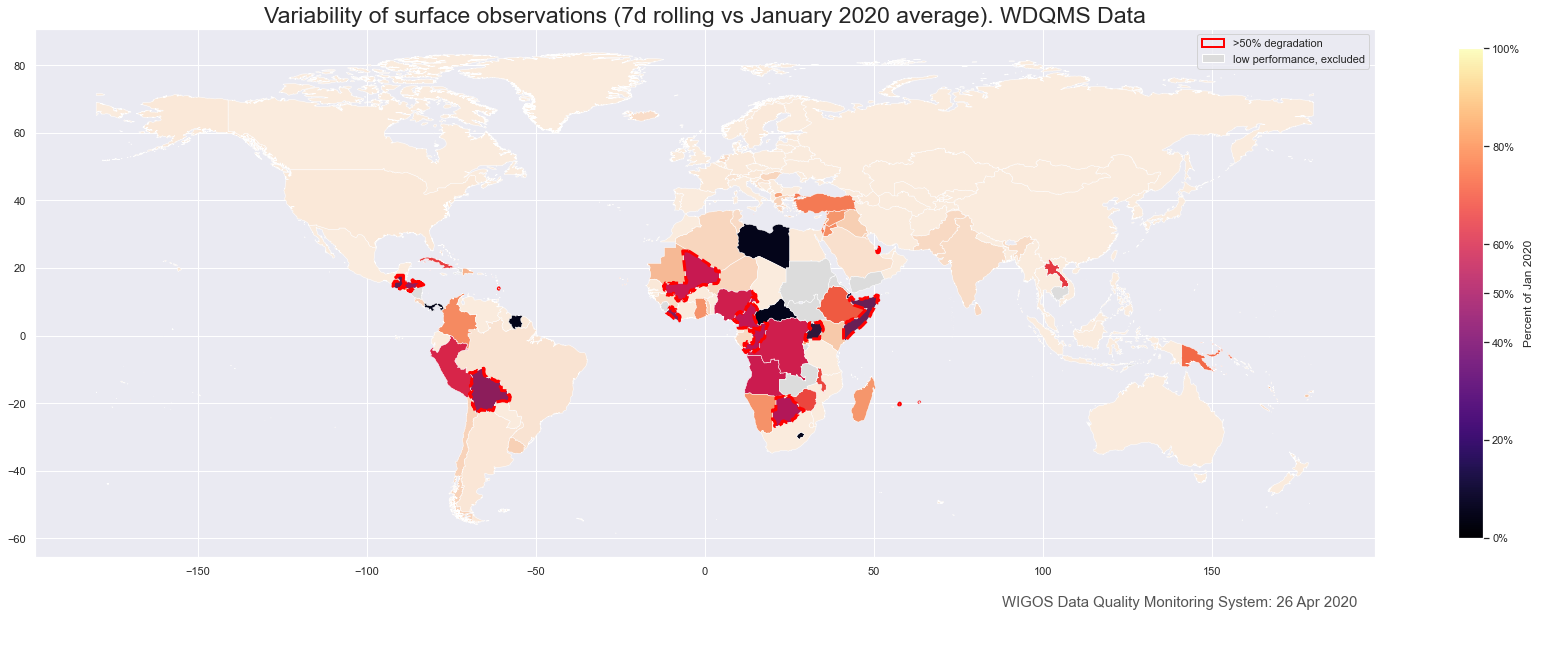

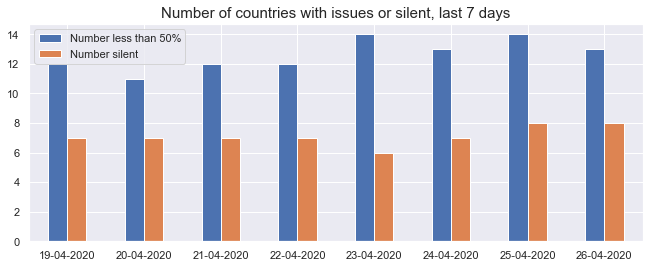

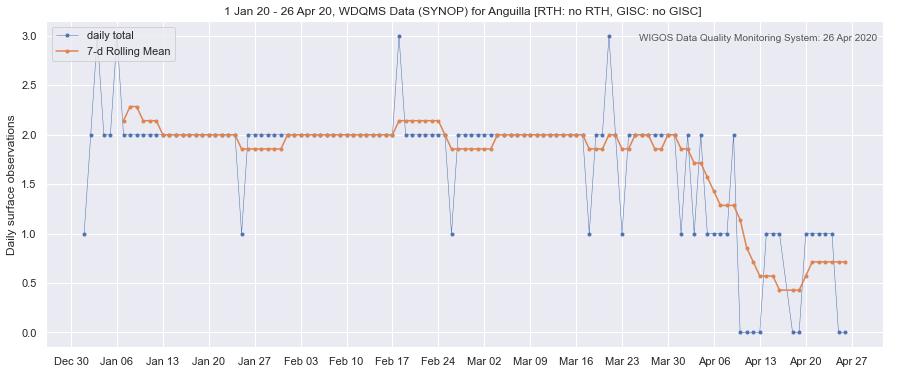

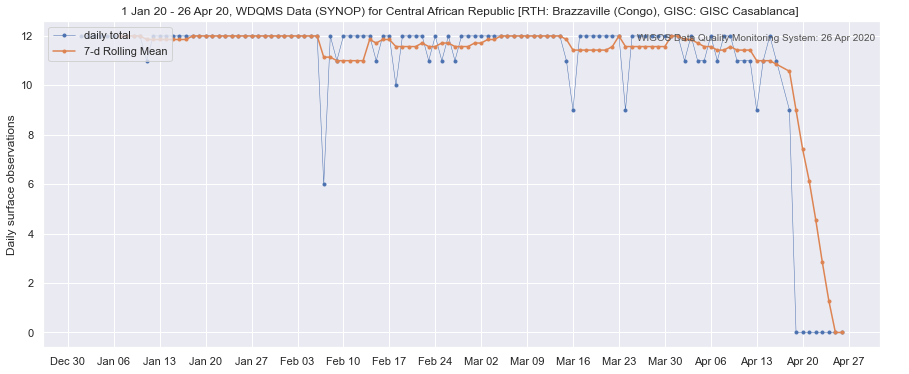

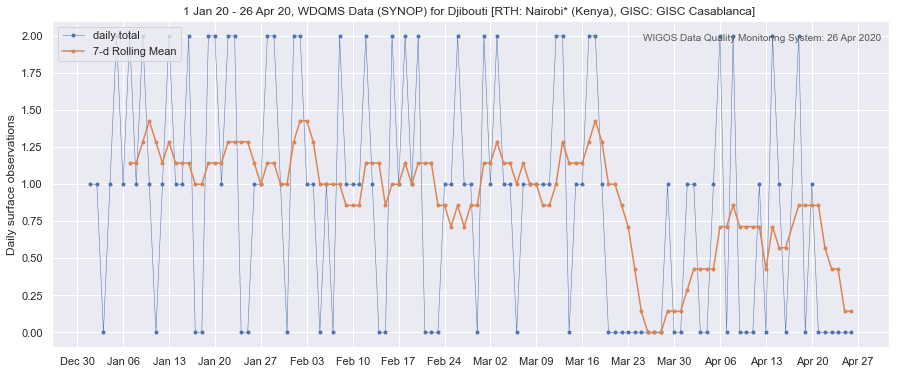

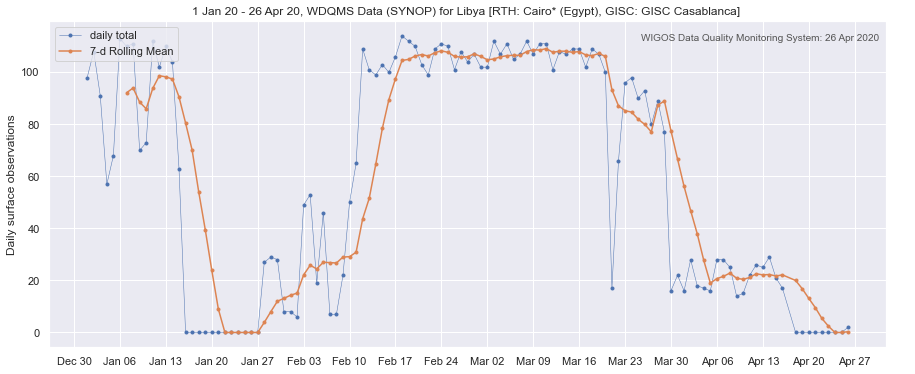

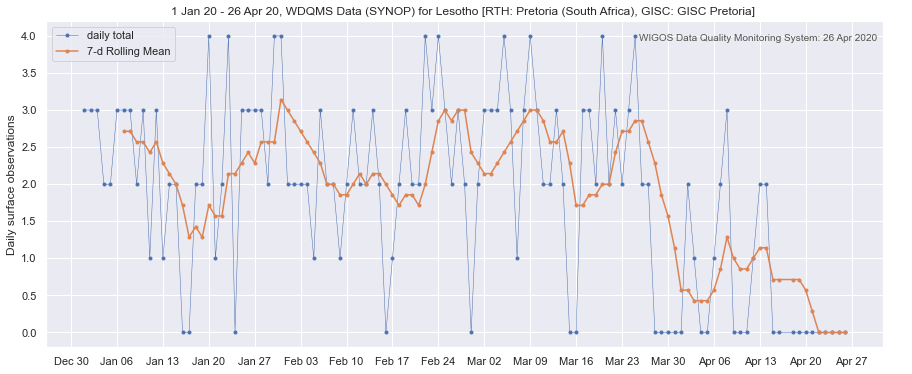

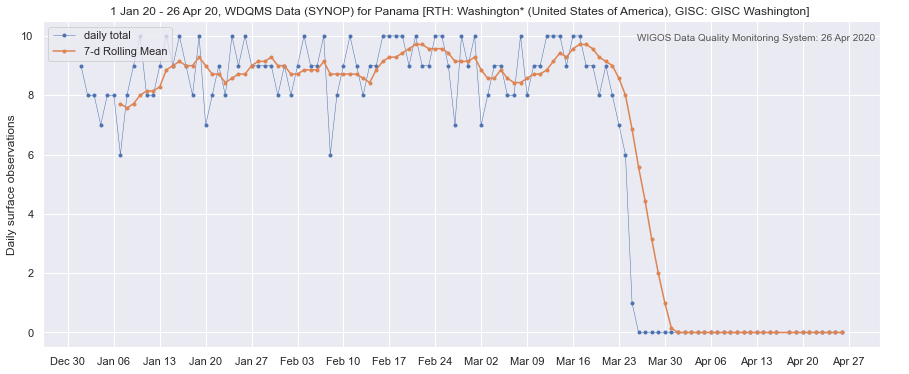

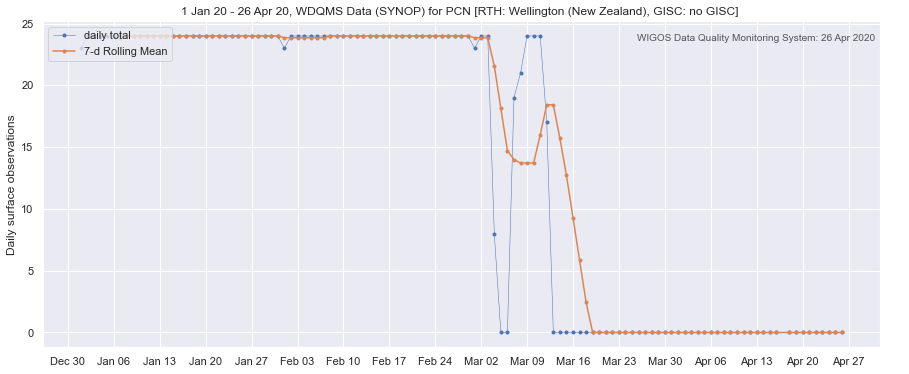

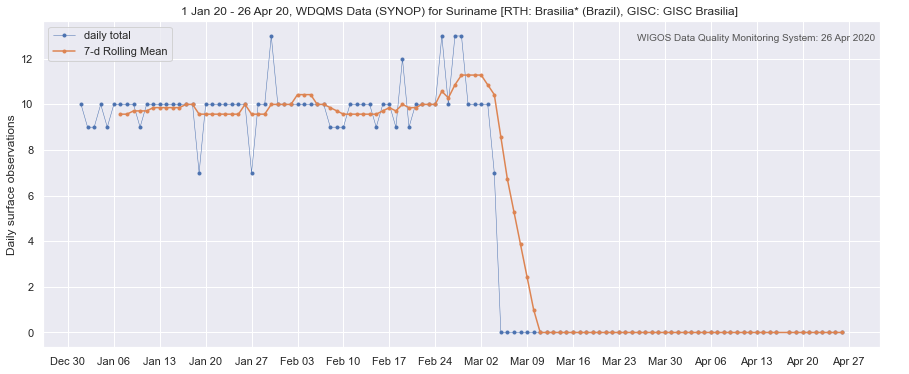

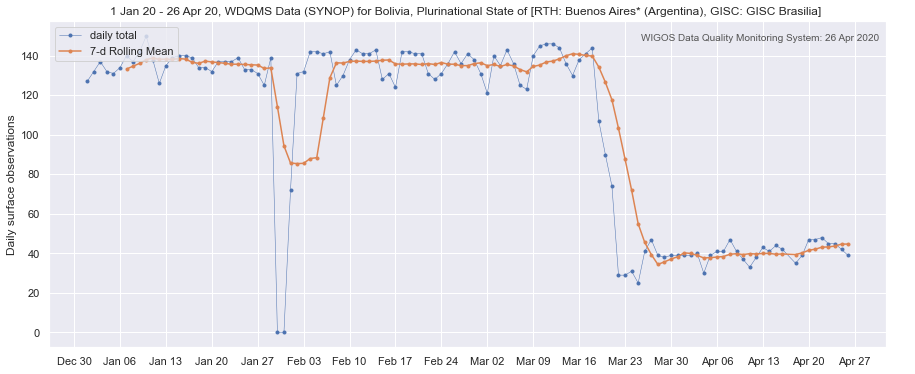

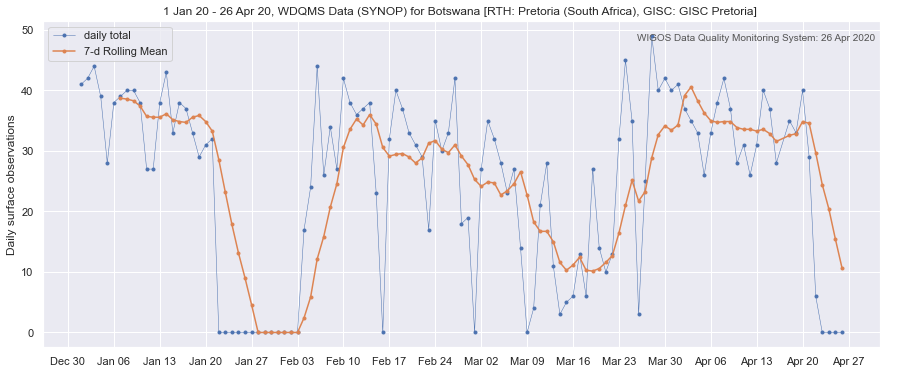

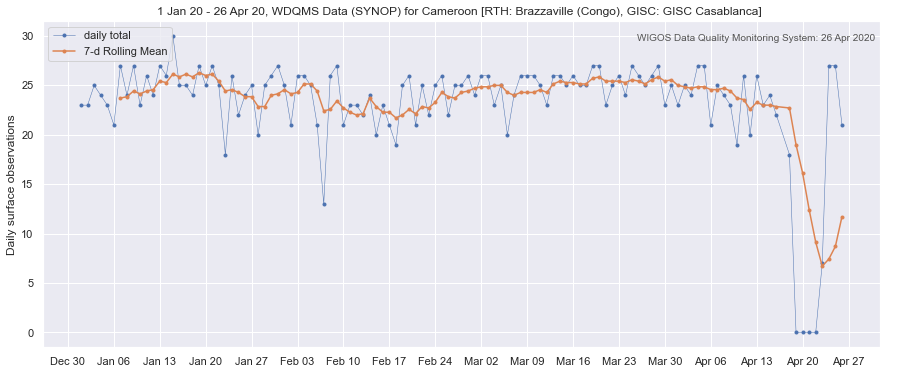

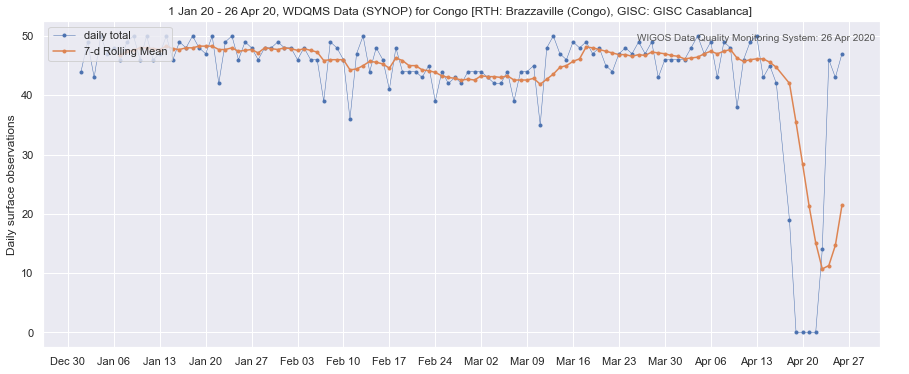

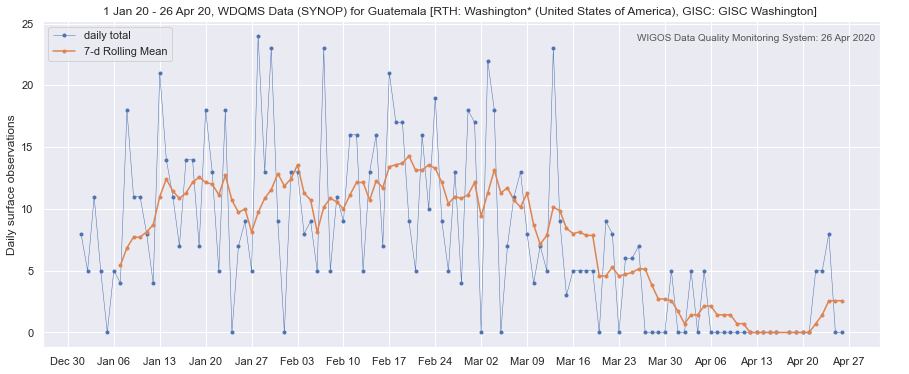

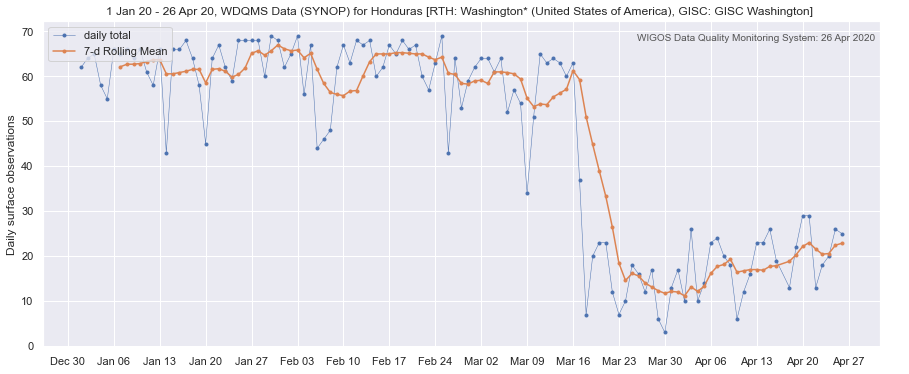

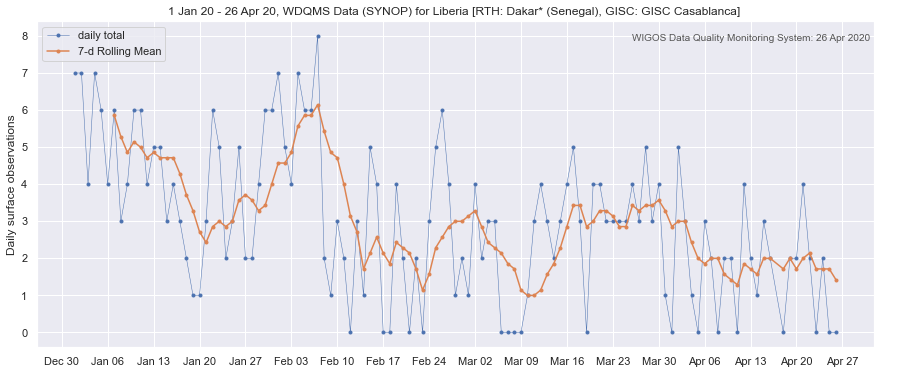

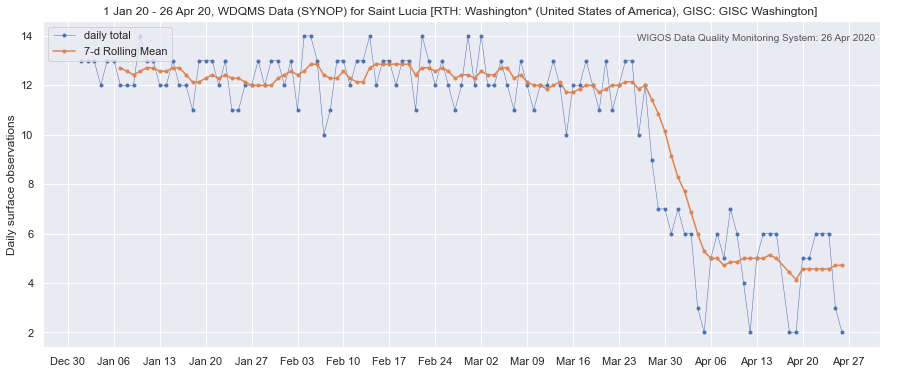

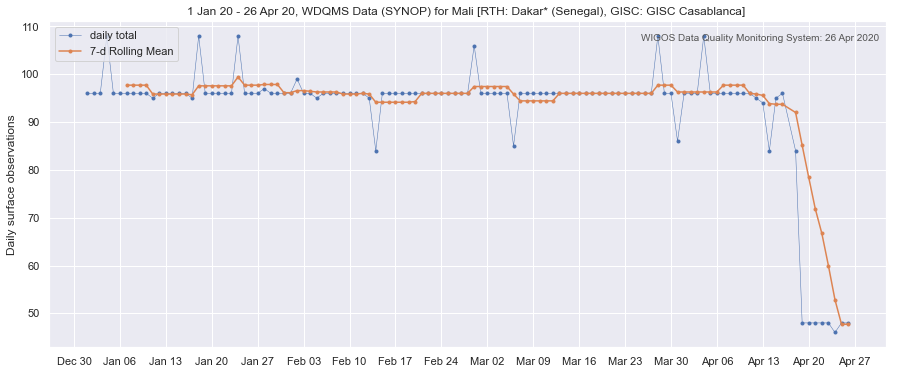

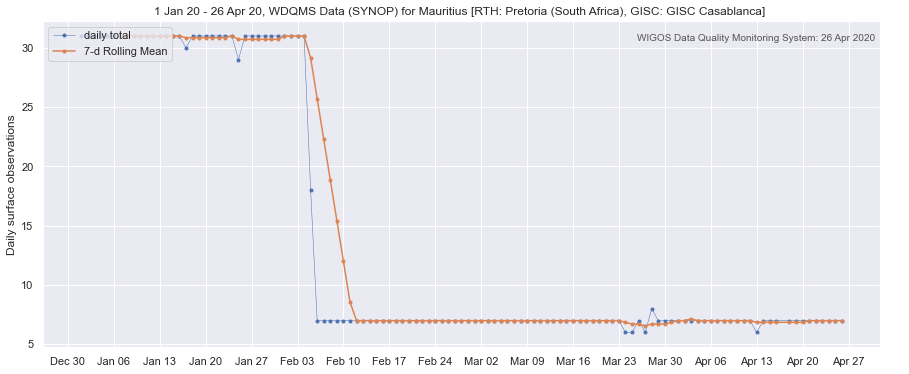

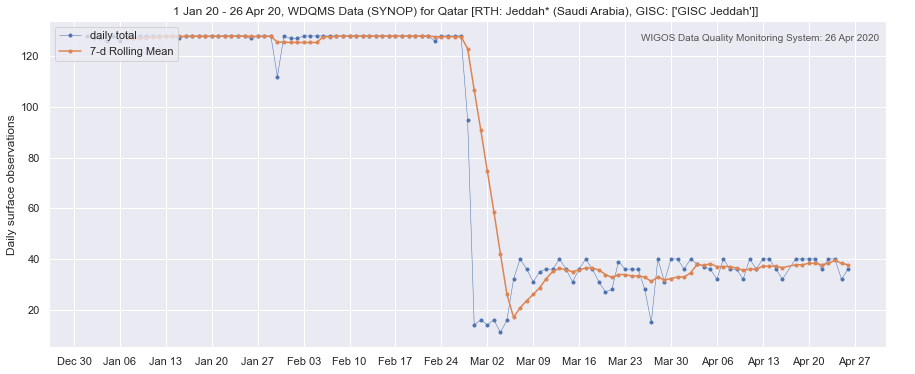

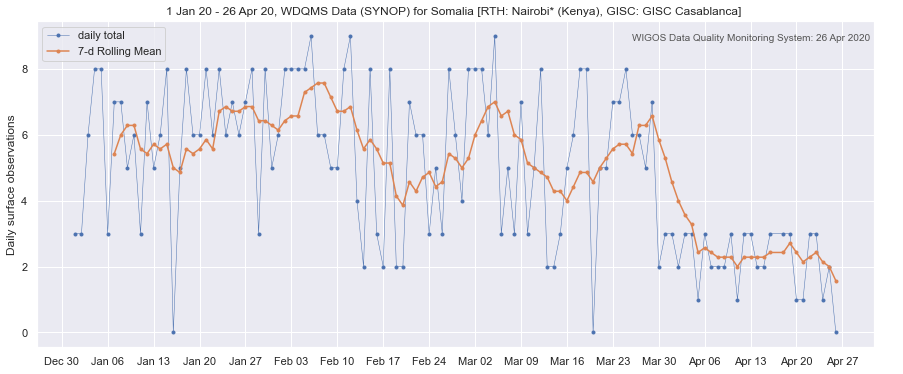

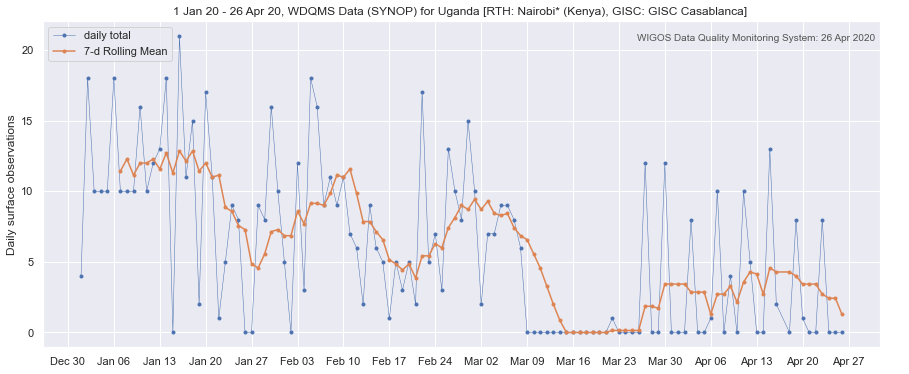

In [16]:
# plotting

gdf=gdf_world.join(df_analysis) # join with 

fig1,ax1=plt.subplots(figsize=(30,12))

#problem_color = "#ed51ff"
problem_color = "red"
silent_color = "#dcdcdc"
    
cmap="magma"
vmin, vmax, vcenter = 0,1,0
        
# normalize color
norm = colors.Normalize(vmin=0, vmax=1)

# create a normalized colorbar
cbar = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    
# plot variance
gdf[gdf.avg_jan>1].plot(edgecolor="white",linewidth=0.5,ax=ax1,column="variance_7d",legend=False,norm=norm)
# plot silent countries       
gdf[gdf.avg_jan<=1].plot(ax=ax1,facecolor=silent_color,linewidth=0.5)
# plot problem countries    
gdf.loc[problem_countries , :].plot(facecolor="none",linewidth=3,ax=ax1,edgecolor=problem_color,
                                      linestyle="--",label="below 50% capacity",legend=True)
   
    
# configure colorbar
ticks = [0,.2,.4,.5,.6,.8,1]
cbar = fig1.colorbar( cbar,ax=ax1 , ticks=ticks , shrink=0.75 )

cbar.set_label('Percent of Jan 2020')
cbar.ax.set_yticklabels( ["{}%".format(int(r*100)) for r in ticks] )
        
        
# additional legend
red_patch = mpatches.Patch(edgecolor=problem_color, linewidth=2, facecolor="None", label='>50% degradation')
grey_patch = mpatches.Patch(facecolor="#dcdcdc", label='low performance, excluded')
plt.legend(handles=[red_patch,grey_patch])
    
# title and annotation        
ax1.set_title("Variability of surface observations (7d rolling vs January 2020 average). WDQMS Data", fontsize=23)        
ax1.annotate("WIGOS Data Quality Monitoring System: {:%d %b %Y}".format(lastdate),xy=(.65, .10),  
             xycoords="figure fraction", horizontalalignment="left", verticalalignment="top", 
             fontsize=15, color="#555555")

# write out map
fig1.savefig( os.path.join(output_dir, mapplot_file.format(lastdate) ) ,bbox_inches="tight")

# barplot
tmp = df_analysis.loc[~idx_low_perfomance,:]

idx_silent = tmp[new_cols] < 1
idx_problem = tmp[new_cols].lt( tmp.avg_jan *  cutoff , axis="index" )

nr_problem_countries = (idx_problem & ~idx_silent).sum()
nr_silent_countries = idx_silent.sum()

fig,ax=plt.subplots()

pd.concat([nr_problem_countries,nr_silent_countries],axis=1).rename(columns={0:"Number less than 50%",1:"Number silent"}).plot.bar(ax=ax,rot=0)
ax.set_xticklabels( ["{:%d-%m-%Y}".format( lastdate - datetime.timedelta(days=d)  ) for d in reversed(range(0,8,1)) ]  )
ax.set_title("Number of countries with issues or silent, last 7 days",fontsize=15)
fig.savefig( os.path.join(output_dir,barplot_file.format(lastdate)))

# timeplots 

df_rth = pd.read_csv("RTH_areas.csv",encoding="latin1").set_index("RTH area of responsibility ISO3") # for RTH and GISC info
df_rth = df_rth.loc[~df_rth.index.duplicated(keep='first')]


df_gisc=pd.read_csv("Country-2-GISC.csv",encoding="latin1").set_index("ISO3 code (Member) (Member/Partner)")
df_gisc=df_gisc[df_gisc.Category=="NC"][["Principal",]]


all_countries = silent_countries+problem_countries
all_countries_labels = silent_countries_labels+problem_countries_labels

for country_id,country in zip(all_countries,all_countries_labels):   
    #print("processing",country_id,country)
 
    fig2,ax2=plt.subplots(figsize=(15,6))

    # plot daily totals
    ax2.plot(df.loc[:,country_id] , marker='.', linestyle='-',linewidth=0.5,label="daily total")
    
    # plot rolling
    ax2.plot(df_7d.loc[:,country_id],marker='.', linestyle='-', label='7-d Rolling Mean')

    
    ax2.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY))
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
        
    ax2.legend(loc="upper left")

    # title, label and annotation of timeplot
    if country_id in df_rth.index:
        rth = df_rth.loc[country_id,"RTH city"]
    else:
        rth = "no RTH"
    
    if country_id in df_gisc.index:
        if df_gisc.loc[country_id,["Principal",]].size==1:
            gisc = df_gisc.loc[country_id,["Principal",]].values[0]
        else:
            gisc = df_gisc.loc[country_id,["Principal",]].values[-1]
    else:
        gisc = "no GISC"
        
    
    ax2.set_ylabel("Daily surface observations")
    params = {"from":firstdate,"to":lastdate,"country":country,"rth":rth,"gisc":gisc}
    ax2.set_title("{from:%#d %b %y} - {to:%#d %b %y}, WDQMS Data (SYNOP) for {country} [RTH: {rth}, GISC: {gisc}] ".format(**params))
    ax2.annotate("WIGOS Data Quality Monitoring System: {:%d %b %Y}".format(lastdate),xy=(.7, .91),  
                     xycoords="figure fraction", horizontalalignment="left", verticalalignment="top", 
                     fontsize=10, color="#555555")
     
    # write out timeplot
    fig_path = os.path.join(output_dir , timeplot_file.format(country_id,lastdate))
    fig2.savefig( fig_path ,bbox_inches="tight")
    #print("saved",fig_path)
 

In [17]:
from fpdf import FPDF
# create PDF
class CustomPDF(FPDF):
    
    def header(self):
        # Set up a logo
        self.image('wmo-logo.png', 10, 2, 33)
        self.set_font('Arial', 'B', 12)
        
        # Add an address
        self.cell(100)
        self.cell(0, 5, 'WIGOS Data Quality Monitoring System', ln=1)
        self.cell(100)
        self.cell(0, 5, 'WMO Secretariat', ln=1)
        
        # Line break
        self.ln(5)
        
    def footer(self):
        self.set_y(-10)
        
        self.set_font('Arial', 'I', 8)
        
        # Add a page number
        page = 'Page ' + str(self.page_no()) + '/{nb}, ' + "generated {:%d/%m/%Y}".format(datetime.datetime.today()) 
        self.cell(0, 10, page, 0, 0, 'C')

In [18]:
pdf = CustomPDF()
pdf.alias_nb_pages()
pdf.add_page()
pdf.set_font("Arial", size=14)
pdf.cell(200, 10, txt="WDQMS surface observing system report for {:%A, %d %b %Y}".format(datetime.datetime.today()), ln=1, align="C")

link="https://wmoomm.sharepoint.com/:f:/s/wmocpdb/EplLChwJNoJOg3hPrGPo5tcBjVreayJGDk98dd2aU6KLOQ?e=TmCxOD"
pdf.set_font("Arial", size=10)
pdf.cell(170,10,txt='Download latest copy', link=link,align="R",ln=1);

pdf.set_font("Arial", size=8)

into_para1 = """The number of observations exchanged on WIS/GTS by WMO Members is subject to daily variability due to several types of issues involving: observation facility or instruments, data processing, telecommunication. The following maps and plots are monitoring the total numbers of observations exchanged by each Member and can be used to identify problems at National level that usually concern telecommunications, central processing or changes in the management of observation facilities and data at National level. """
into_para2 = """The daily variability can be extremely significant and in some cases the complete loss of data from one Member for some days is possible. Usually, these events are rare and are corrected with the support of a GISC or RTH. The aim of the following maps is to identify situations where the loss of data from a Member is persistent for at least a week, for this purpose the maps are reporting the seven day rolling average of observations exchanged by a Country over a reference average value that in the specific case is the average of January 2020."""
into_para3 = """In the following map, the Countries in black have not exchanged any data for the week preceding the date of the map, while the Countries with a red border are exchanging data at less than 50% the average of January 2020. For the Countries in black some urgent action needs to be taken to understand if there is any kind of national issues for which WMO can provide support to the Member. """

pdf.multi_cell(190, 5, txt=into_para1,align="L")
pdf.ln(2)
pdf.multi_cell(190, 5, txt=into_para2,align="L")
pdf.ln(2)
pdf.multi_cell(190, 5, txt=into_para3,align="L")
pdf.ln(2)

image_path = os.path.join(output_dir, mapplot_file.format(lastdate) )
pdf.image(image_path,  w=200)
pdf.set_font("Arial", size=12)
#pdf.ln(85)  # move 85 down
#pdf.cell(200, 10, txt="{}".format(image_path), ln=1)

#problem_countries = sorted(['Ethiopia', 'Guatemala', 'Honduras', 'Madagascar', 'Mauritius', 'Panama', 'PCN', 'Papua New Guinea', 'Qatar', 'El Salvador', 'Suriname', 'Uganda'])
#silent_countries = sorted(['Bolivia, Plurinational State of', 'Djibouti', 'Ecuador'])

problem_c = dict(zip(problem_countries,problem_countries_labels))
silent_c = dict(zip(silent_countries,silent_countries_labels))

problem_c_str = ", ".join( [ problem_c[k] for k in sorted(problem_c.keys()) ] )
silent_c_str = ", ".join( [ silent_c[k] for k in sorted(silent_c.keys()) ] )

pdf.multi_cell(200, 5, txt="The observing system has been silent in {}".format(silent_c_str),align="L")
pdf.ln(3)  # move 10 down
pdf.multi_cell(200, 5, txt="The observing system is working at less than 50% capacity in {}".format(problem_c_str),align="L")
pdf.ln(2)  # move 10 down

bar_path = os.path.join(output_dir,barplot_file.format(lastdate))
pdf.image(bar_path,w=150)

pdf.add_page()

pdf.set_font("Arial", style="BI", size=13)
pdf.cell(200, 10, txt="Timeplots of silent (<1 daily observation) countries", ln=1, align="C")
pdf.ln(10)  # move 10 down

for iso3 in sorted(silent_c.keys()):
    file = os.path.join(output_dir,timeplot_file.format(iso3,lastdate))
    if os.path.exists(file):
        pdf.image(file,  w=200)
    else:
        raise Exception("{} does not exist".format(file))

pdf.add_page()
pdf.set_font("Arial", style="BI", size=13)
pdf.cell(200, 10, txt="Timeplots of countries at less than 50% capacity", ln=1, align="C")
pdf.ln(10)  # move 10 down

for iso3 in sorted(problem_c.keys()):
    file = os.path.join(output_dir,timeplot_file.format(iso3,lastdate))
    if os.path.exists(file):
        pdf.image(file,  w=200)
    else:
        raise Exception("{} does not exist".format(file))

output_file  = os.path.join( output_dir , "reports/wdqms_surface_report_{:%Y-%m-%d}.pdf".format(datetime.datetime.today()))
pdf.output( output_file )
print("wrote:",output_file)

wrote: C:\Users\Timo\OneDrive - WMO\WDQMS-monitoring\reports/wdqms_surface_report_2020-04-27.pdf
